In [1]:
import numpy as np
import torch 
from collections import OrderedDict

from utils.train_n_test import TrainTest

from models.CNN_1D import CNN_1D
from models.LSTM_CNN_concat import LSTM_CNN_concat
from models.LSTM import LSTM_gi
from models.MLP import MLP

from utils.visuals import lagged_correlation
from utils.custom_loss import Balance
import matplotlib
import matplotlib.pyplot as plt

# Running Experiments

In [2]:
N = 10
FIX = True
PKL_NAME = 'expt48'

### 1DCNN

In [ ]:
fixed_params = [{'BATCH_SIZE': 256,
  'EPOCHS': 20,
  'OPTIMIZER': torch.optim.RMSprop,
  'LEARNING_RATE': 0.0001,
  'LOSS': torch.nn.MSELoss(), 
  'EARLY_STOPPING': True,
  'PATIENCE': 2,
  'MIN_DELTA': 1e-06,
  'HIDDEN_DEPTH': 4,
  'HIDDEN_SIZES': np.array([64,128, 256, 512]),
  'KERNEL_SIZES': np.array([9, 7, 5, 3]),
  'MAXPOOL': 2,
  'FC_DEPTH': 2,
  'FC_SIZES': np.array([512]),
  'DROPOUT': 0.2}]

for i in np.arange(N): 
    train, val, test = torch.load('data/tensors/'+ PKL_NAME + '.pkl')
    persistence = torch.load('data/tensors/'+ PKL_NAME + '_persistence.pkl')     

    print(fixed_params[0])
    run = TrainTest(CNN_1D, (train, val, test), fixed_params[0], class_size=1)
    run.train()
    run.test()
    torch.save(run.model, 'models/pkl/1DCNN_model'+str(i)+'.pt')

### CNN_LSTM

In [ ]:
balance_params = {
    'START': 1e7, 
    'REWARD': 10, 
    'FINE': 100, 
    'NORM_HYPERPARAMS': (0,87000),
    'NORM': 'minmax',
    'WARM': 1
}

fixed_params =[{'BATCH_SIZE': 256,
  'EPOCHS': 20,
  'OPTIMIZER': torch.optim.RMSprop,
  'LEARNING_RATE': 0.001,
  'LOSS': torch.nn.MSELoss(),
  'EARLY_STOPPING': True,
  'PATIENCE': 1,
  'MIN_DELTA': 5e-06,
  'DROPOUT': 0.1,
  'CNN_HIDDEN_DEPTH': 4,
  'CNN_HIDDEN_SIZES': np.array([ 64, 128, 256, 512]),
  'KERNEL_SIZES': np.array([9,7, 5, 3]),
  'MAXPOOL': 2,
  'LSTM_HIDDEN_DIM': 128,
  'NUM_LAYERS': 1,
  'BIDIRECTIONAL': True,
  'FC_DEPTH': 1,
  'FC_SIZES': np.array([512]),
  'BALANCE': balance_params
               }]

for i in np.arange(N): 
    train, val, test = torch.load('data/tensors/'+ PKL_NAME + '.pkl')
    persistence = torch.load('data/tensors/'+ PKL_NAME + '_persistence.pkl')     

    print(fixed_params[0])
    run = TrainTest(LSTM_CNN_concat, (train, val, test), fixed_params[0], class_size=1)
    run.train()
    run.test()
    torch.save(run.model, 'models/pkl/LSTM_CNN_model'+str(i)+'.pt')

### LSTM

In [ ]:
balance_params = {
    'START': 1e7, 
    'REWARD': 10, 
    'FINE': 100, 
    'NORM_HYPERPARAMS': (0,87000),
    'NORM': 'minmax',
    'WARM': 1
}

fixed_params =[{'BATCH_SIZE': 256,
  'EPOCHS': 20,
  'OPTIMIZER': torch.optim.RMSprop,
  'LEARNING_RATE': 0.001,
  'LOSS': torch.nn.MSELoss(),
  'EARLY_STOPPING': True,
  'PATIENCE': 2,
  'MIN_DELTA': 5e-06,
  'DROPOUT': 0.1,
  'HIDDEN_DIM': 128,
  'NUM_LAYERS': 1,
  'BIDIRECTIONAL': True,
  'FC_DEPTH': 1,
  'FC_SIZES': np.array([512]),
  'BALANCE': balance_params}]

for i in np.arange(N): 
    train, val, test = torch.load('data/tensors/'+ PKL_NAME + '.pkl')
    persistence = torch.load('data/tensors/'+ PKL_NAME + '_persistence.pkl')     

    print(fixed_params[0])
    run = TrainTest(LSTM_, (train, val, test), fixed_params[0], class_size=1)
    run.train()
    run.test()
    torch.save(run.model, 'models/pkl/LSTM_model'+str(i)+'.pt')

### MLP 

In [ ]:
balance_params = {
    'START': 1e7, 
    'REWARD': 10, 
    'FINE': 100, 
    'NORM_HYPERPARAMS': (0,87000),
    'NORM': 'minmax',
    'WARM': 1
}

fixed_params =[{'BATCH_SIZE': 256,
  'EPOCHS': 20,
  'OPTIMIZER': torch.optim.RMSprop,
  'LEARNING_RATE': 0.001,
  'LOSS': torch.nn.MSELoss(),
  'EARLY_STOPPING': True,
  'PATIENCE': 2,
  'MIN_DELTA': 5e-06,
  'DROPOUT': 0.1,
  'FC_DEPTH': 4,
  'FC_SIZES': np.array([1024, 512, 256, 128]),
  'BALANCE': balance_params}]

for i in np.arange(N): 
    train, val, test = torch.load('data/tensors/'+ PKL_NAME + '.pkl')
    persistence = torch.load('data/tensors/'+ PKL_NAME + '_persistence.pkl')     

    print(fixed_params[0])
    run = TrainTest(MLP, (train, val, test), fixed_params[0], class_size=1)
    run.train()
    run.test()
    torch.save(run.model, 'models/pkl/MLP_model'+str(i)+'.pt')

# Plotting Visuals

In [3]:
train, val, test = torch.load('data/tensors/'+ PKL_NAME + '.pkl')
persistence = torch.load('data/tensors/'+ PKL_NAME + '_persistence.pkl')  
loss = torch.nn.MSELoss()

In [4]:
%%time
res = {}
for filename in ['1DCNN', 'LSTM_CNN', 'LSTM', 'MLP']:
    res[filename] = {}
    res[filename]['raw'] = []
    res[filename]['test_list'] = []
    res[filename]['bal_list'] = []
    res[filename]['corr'] = []
    for i in np.arange(10):
        mod = torch.load("models/pkl/"+filename+"_model"+str(i)+".pt")
        pred = mod(test[0]).squeeze()
        del mod
        bal = Balance(1e7, 10, 100, (0,87000), 'minmax')
        to_add = test[0][:-1,1]
        bal.update(pred[18:], test[1][18:], test[0][18:,-1,1])
        res[filename]['raw'].append(pred.detach().numpy())
        res[filename]['bal_list'].append(np.array(bal.balance_list))
        res[filename]['test_list'].append(loss(pred, test[1]))
        res[filename]['corr'].append(lagged_correlation(pred.detach().numpy() + test[0][:,-1,1].detach().numpy(), 
                                                        test[1].detach().numpy() + test[0][:,-1,1].detach().numpy(), 
                                                        plot=False))
        
    res[filename]['mean'] = np.mean(np.array(res[filename]['raw']), axis=0)
    res[filename]['std'] = np.std(np.array(res[filename]['raw']), axis=0)
    res[filename]['mean_bal'] = np.mean(np.array(res[filename]['bal_list']), axis=0)
    res[filename]['std_bal'] = np.std(np.array(res[filename]['bal_list']), axis=0)
    res[filename]['mean_corr'] = np.mean(np.array(res[filename]['corr']), axis=0)
    res[filename]['std_corr'] = np.std(np.array(res[filename]['corr']), axis=0)
    
    del res[filename]['raw'] 
    del res[filename]['bal_list']
    del res[filename]['corr'] 

CPU times: user 24.1 s, sys: 26.7 s, total: 50.8 s
Wall time: 13.3 s


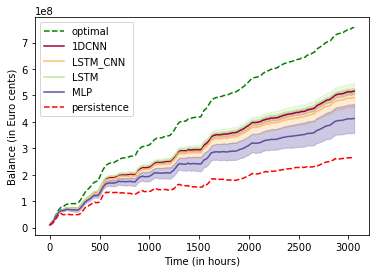

In [40]:
cmap = plt.get_cmap('Spectral', 4)
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

perfect_bal = Balance(1e7, 10, 100, (0,87000), 'minmax')
perfect_bal.update(test[1][18:], test[1][18:], test[0][18:,-1,1])

persist_bal = Balance(1e7, 10, 100, (0,87000), 'minmax')
temp_persist = persistence[18:] + test[0][:-18,-1,1] - test[0][18:,-1,1] # change to difference with y0 instead of y-18
persist_bal.update(temp_persist, test[1][18:], test[0][18:,-1,1])

fig = plt.figure()
plt.plot(perfect_bal.balance_list, label='optimal', color='g', linestyle='dashed')
for i,k in enumerate(res): 
    plt.plot(res[k]['mean_bal'], color=colors[i], label = k)
    plt.fill_between(range(len(res[k]['mean_bal'])),
                 res[k]['mean_bal'] - res[k]['std_bal'], 
                 res[k]['mean_bal'] + res[k]['std_bal'],
                 color=colors[i], alpha=0.3)
plt.plot(persist_bal.balance_list, label='persistence', color='r', linestyle='dashed')

plt.xlabel('Time (in hours)')
plt.ylabel('Balance (in Euro cents)')
plt.legend(loc='upper left')

plt.show() 

#fig.savefig('results/visuals/compare_model_balances' + PKL_NAME +'.jpg')

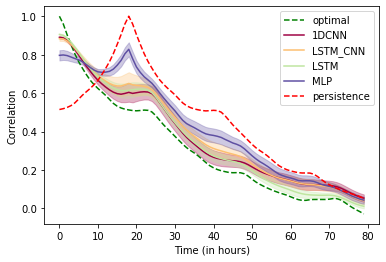

In [34]:
cmap = plt.get_cmap('Spectral', 4)
colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

## Visualise Lagged Correlation
corr_perf = lagged_correlation((test[1][18:] + test[0][18:,-1,1]), (test[1][18:] + test[0][18:,-1,1]))
corr_pers = lagged_correlation((persistence[18:] + test[0][:-18,-1,1]), (test[1][18:] + test[0][18:,-1,1]))

fig = plt.figure()
plt.plot(corr_perf, label='optimal', color='g', linestyle='dashed')
for i,k in enumerate(res): 
    plt.plot(res[k]['mean_corr'], color=colors[i], label = k)
    plt.fill_between(range(len(res[k]['mean_corr'])),
                 res[k]['mean_corr'] - res[k]['std_corr'], 
                 res[k]['mean_corr'] + res[k]['std_corr'],
                 color=colors[i], alpha=0.3)
plt.plot(corr_pers, label='persistence', color='r', linestyle='dashed')

plt.xlabel('Time (in hours)')
plt.ylabel('Correlation')
plt.legend(loc='upper right')

plt.show()

#fig.savefig('results/visuals/lagged_correlation' + PKL_NAME +'.jpg')